### Imports & Harris Boundary

<Axes: >

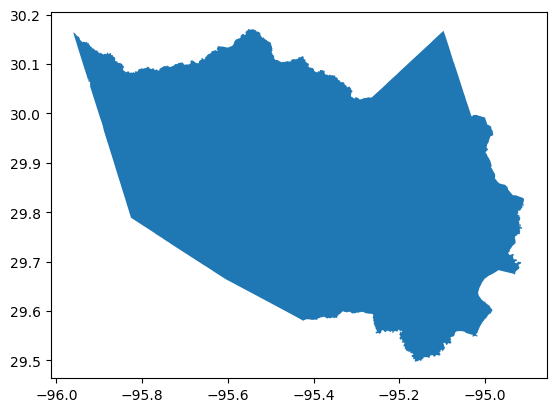

In [ ]:
################### IMPORTS #######################
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import zipfile
from shapely.geometry import Point
import pandas as pd
import glob
from osgeo import gdal
from datetime import datetime

harris_county = gpd.read_file("harris_county.geojson")

harris_county.plot()

In [ ]:
# harris_county.to_file("harris_county.geojson", driver="GeoJSON")


### Constants

In [52]:
wastewater_path = "/home/sd96/wastewater"
arrays_path = os.path.join(wastewater_path, "Arrays")
csvs_path = os.path.join(wastewater_path, "CSVS")

In [68]:
var_labels_to_name = {'ppt': 'Precip', 'tmean':'Tmean', 'tdmean': 'Tdmean'}
var_to_full_name = {'ppt': 'Precipitation', 'tmean': 'Temperature', 'tdmean': 'Dew Point Temperature'}

## Functions

### Plot Average From CSV File

In [121]:
def plot_average_from_csv(csv_path, harris_county_border, varname="variable"):
    """
    Plot the average variable value per point from a CSV over Harris County.

    Params:
        csv_path (str): Path to the CSV file created from PRISM data
        harris_county_border (GeoDataFrame): Harris County boundary
        variable_name (str): Column name of the variable in the CSV
    """
    # Load CSV
    print("Using data from CSV at", csv_path)
    df = pd.read_csv(csv_path)

    col_name = var_labels_to_name[varname]
    print("col name", col_name)
    # Group by lat/lon and compute mean value
    avg_df = df.groupby(['Lat', 'Lon'])[col_name].mean().reset_index()

    variable_full_name = var_to_full_name[varname]

    print(variable_full_name)
    print(avg_df.columns)
    # Plot
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(avg_df["Lon"], avg_df["Lat"], c=avg_df[col_name], cmap='viridis', s=40)
    plt.colorbar(sc, label=f"Avg {variable_full_name}")
    plt.title(f"Average Monthly {variable_full_name} in Harris County ({csv_path})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    harris_county_border.boundary.plot(ax=plt.gca(), edgecolor="black", linewidth=1)
    plt.gca().set_aspect("equal")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


### Get Time From File name

In [122]:
            
def get_time_from_file_name(fname): 
    
    # fname = os.path.basename(bil_file)
    # Sample file name: PRISM_ppt_stable_4kmD2_20210102_bil.bil
    
    base_name = fname.replace("_bil.bil", "") 
    date_str = base_name.split("_")[-1]       
    try: 
        # print(f"Parsing date: '{date_str}' from file '{fname}'")

        year = int(date_str[:4])
        month = int(date_str[4:6])
        day = int(date_str[6:8])
                
        dt = datetime(year, month, day)
                    
        # time_list.append(dt)
        print(f"Successfully parsed date: {dt}")
        return dt 
    except Exception as e:
        print(f"Unable to parse date for file {fname}")
        print(f"base_name: {base_name}")
        print(f"date_str: '{date_str}'")
        print(f"Error: {e}")
        return None

### Raw PRISM To Arrays

In [124]:
def extract_prism_data(base_dir, years, varname, harris_boundary, 
                       lat_range=(29.3, 30.25), 
                       lon_range=(-96.0, -94.8)): 
    """
    Converts data from a given BIL folder for daily PRISM data to np arrays
    
    Returns: 
    - data_array: (time_shape, points_shape)
    - lat: (points_shape)
    - lon: (points_shape)
    - time_list: (time_shape)
    - mask: mask used for harris county 
    
    Expected Shapes: 
        data shape (366, 247)
        lat shape (247,)
        lon shape (247,)
        time shape (366,)
    """
    if harris_boundary.crs != "EPSG:4326":
        harris_boundary = harris_boundary.to_crs("EPSG:4326")
        
    first_year = years[0]
    
    sample_file = os.path.join(
        base_dir,
        f"PRISM_{varname}_stable_4kmD2_{first_year}0101_{first_year}1231_bil",
        f"PRISM_{varname}_stable_4kmD2_{first_year}0101_bil.bil"
    )
    
    dataset = gdal.Open(sample_file)
    transform = dataset.GetGeoTransform() 
    width = dataset.RasterXSize 
    height = dataset.RasterYSize 
    
    lon = np.linspace(transform[0], transform[0] + transform[1] * width, width)
    lat = np.linspace(transform[3] + transform[5] * height, transform[3], height)
    
    print(f"Lon shape {lon.shape}")    
    lon2d, lat2d = np.meshgrid(lon, lat)
    # print(lon2d)
    
    flat_points = gpd.GeoSeries([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())], crs="EPSG:4326")

    within_harris = flat_points.within(harris_boundary.geometry.iloc[0])
    
    mask = within_harris.to_numpy().reshape(lat2d.shape)
    
    lon_array = lon2d[mask]
    lat_array = lat2d[mask]
    print("lon shape", lon_array.shape)
    print("lat shape", lat_array.shape)
    # print(f"Mask created with {np.sum(mask)} points inside Harris County.")

    #     # Visualize Points being used
    # fig, ax = plt.subplots(figsize=(10, 6))
    # harris_boundary.boundary.plot(ax = ax, color = 'black')
    # ax.scatter(lon2d[mask], lat2d[mask], 
    #            s = 5, color='red', alpha=0.6, 
    #            label = 'Result of mask')
    # ax.set_xlabel("Longitude")
    # ax.set_ylabel("Latitude")
    # ax.grid(True)
    # ax.legend()
    # plt.show()
    # print(sample_file)
    
    data_list = []
    time_list = []
    
    for year in years: 
        
        # Get directory path for this year
        data_dir = os.path.join(base_dir, f"PRISM_{varname}_stable_4kmD2_{year}0101_{year}1231_bil")
        
        print("Using Data Dir", data_dir)
        bil_files = sorted(glob.glob(os.path.join(data_dir, "*.bil")))
        
        for bil_file in bil_files: 
            dataset = gdal.Open(bil_file)
            if dataset is None: 
                print(f"ERROR: Unable to open file at {bil_file}")    
                continue 
            
            data = dataset.ReadAsArray()
            nodata_value = dataset.GetRasterBand(1).GetNoDataValue()
            masked_data = np.where((mask) & (data != nodata_value), data, np.nan)

            # print("Masked Data Shape:", masked_data.shape)            
            masked_vals = data[mask]
            
            # Add data from this day to the list for the year
            data_list.append(masked_vals)
            
            # Get date from file name
            date = get_time_from_file_name(bil_file)
            
            time_list.append(date)
            
            
    data_array = np.array(data_list)
    time_array = np.array(time_list)
    return data_array, lat_array, lon_array, time_array, mask
            # print("date", date)
            # print("vals shape", masked_vals.shape)
            # fig, ax = plt.subplots(figsize=(10, 6))
            # harris_boundary.boundary.plot(ax = ax)
            # sc = ax.scatter(masked_lons, masked_lats, c = masked_vals)
            # plt.show()
            # break   
            
    # Visualize Points being used
    # fig, ax = plt.subplots(figsize=(10, 6))
    # harris_boundary.boundary.plot(ax = ax, color = 'black')
    # ax.scatter(lon2d[mask], lat2d[mask], 
    #            s = 5, color='red', alpha=0.6, 
    #            label = 'Result of mask')
    # ax.set_xlabel("Longitude")
    # ax.set_ylabel("Latitude")
    # ax.grid(True)
    # ax.legend()
    # plt.show()
    # print(sample_file)

### Save Prism to CSV

In [ ]:
def save_prism_to_csv(data_array, lat_array, lon_array, time_array, varname, output_path):
    
    records = []

    for time_idx, date in enumerate(time_array):
        values = data_array[time_idx]
        for lat, lon, val in zip(lat_array, lon_array, values):
            if not np.isnan(val):
                records.append((date, lat, lon, val))

    df = pd.DataFrame(records, columns=["Date", "Lat", "Lon", var_labels_to_name[varname]])
    df.to_csv(output_path, index='Date')
    print(f"Data saved to {output_path} with {len(df)} records.")


### CSV -> Avg Across Harris

In [156]:
def create_monthly_csv_file(csv_path, varname, output_path):
    df = pd.read_csv(csv_path, index_col="Date")

    print(df.columns)
    # Compute monthly average precipitation
    # Save Data column

    col_name = var_labels_to_name[varname]
    df_monthly_avg = df.groupby("Date")[col_name].mean().reset_index()

    df_monthly_avg.set_index('Date', inplace=True)

    df_monthly_avg.to_csv(output_path, index='Date')
    df_monthly_avg.index = pd.to_datetime(df_monthly_avg.index)
    
    print(df_monthly_avg.columns)


    print(f"Saved Monthly CSV at {output_path}")

    return df_monthly_avg

## Main

### Set Consants 

In [223]:

varname = "tdmean"
year = "2024"
csv_path = os.path.join(csvs_path, f"harris_{varname}_{year}.csv")
daily_avg_csv_path = os.path.join(csvs_path, f"daily_avg_harris_{varname}_{year}.csv")
var_data_path = os.path.join(arrays_path, f"daily_{varname}_{year}")
time_path = os.path.join(arrays_path, f"daily_{varname}_{year}_time")
years = [year]

#### PRISM to Arrays

In [224]:
data, lat, lon, time, mask = extract_prism_data(
    base_dir="/home/sd96/wastewater", 
    years=years, 
    varname=varname, 
    harris_boundary=harris_county
)

Lon shape (1405,)


lon shape (247,)
lat shape (247,)
Using Data Dir /home/sd96/wastewater/PRISM_tdmean_stable_4kmD2_20240101_20241231_bil
Successfully parsed date: 2024-01-01 00:00:00
Successfully parsed date: 2024-01-02 00:00:00
Successfully parsed date: 2024-01-03 00:00:00
Successfully parsed date: 2024-01-04 00:00:00
Successfully parsed date: 2024-01-05 00:00:00
Successfully parsed date: 2024-01-06 00:00:00
Successfully parsed date: 2024-01-07 00:00:00
Successfully parsed date: 2024-01-08 00:00:00
Successfully parsed date: 2024-01-09 00:00:00
Successfully parsed date: 2024-01-10 00:00:00
Successfully parsed date: 2024-01-11 00:00:00
Successfully parsed date: 2024-01-12 00:00:00
Successfully parsed date: 2024-01-13 00:00:00
Successfully parsed date: 2024-01-14 00:00:00
Successfully parsed date: 2024-01-15 00:00:00
Successfully parsed date: 2024-01-16 00:00:00
Successfully parsed date: 2024-01-17 00:00:00
Successfully parsed date: 2024-01-18 00:00:00
Successfully parsed date: 2024-01-19 00:00:00
Success

In [225]:
## Validate Shapes
## Should be 
# data shape (366, 247)
# lat shape (247,)
# lon shape (247,)
# time shape (366,)
print("data shape", data.shape)
print("lat shape", lat.shape)
print("lon shape", lon.shape)
print("time shape", time.shape)

data shape (366, 247)
lat shape (247,)
lon shape (247,)
time shape (366,)


#### Save Arrays

In [226]:
np.save(var_data_path, data)

print(f"Saved {varname} for {year} at {var_data_path}")

np.save(time_path, time)

print(f"Saved time array for {year} at {time_path}")
# np.save(os.path.join(arrays_path, "daily_prism_lat"), lat)
# np.save(os.path.join(arrays_path, "daily_prism_lon"), lon)


Saved tdmean for 2024 at /home/sd96/wastewater/Arrays/daily_tdmean_2024
Saved time array for 2024 at /home/sd96/wastewater/Arrays/daily_tdmean_2024_time


In [227]:
save_prism_to_csv(data, lat, lon, time, varname, csv_path)


Data saved to /home/sd96/wastewater/CSVS/harris_tdmean_2024.csv with 90402 records.


Using data from CSV at /home/sd96/wastewater/CSVS/harris_tdmean_2024.csv
col name Tdmean
Dew Point Temperature
Index(['Lat', 'Lon', 'Tdmean'], dtype='object')


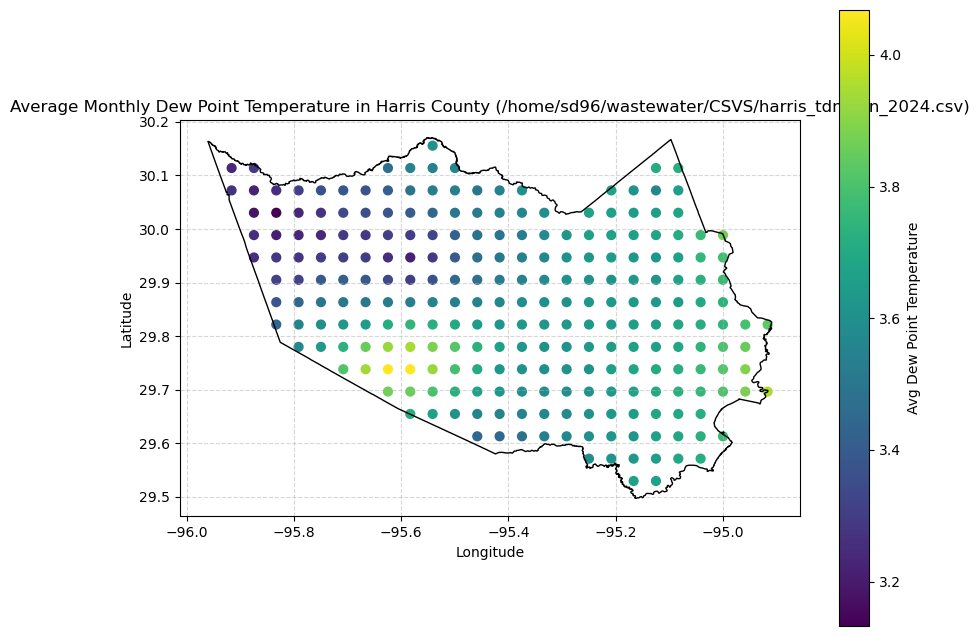

In [228]:
plot_average_from_csv(csv_path, harris_county, varname)

In [229]:
create_monthly_csv_file(csv_path, varname, daily_avg_csv_path)

Index(['Unnamed: 0', 'Lat', 'Lon', 'Tdmean'], dtype='object')
Index(['Tdmean'], dtype='object')
Saved Monthly CSV at /home/sd96/wastewater/CSVS/daily_avg_harris_tdmean_2024.csv


,Tdmean
Date,
2024-01-01,-7.732892
2024-01-02,-5.961657
2024-01-03,-4.051982
2024-01-04,-8.360871
2024-01-05,-6.564604
...,...
2024-12-27,1.159255
2024-12-28,2.083285
2024-12-29,1.478921
